<a href="https://colab.research.google.com/github/RanwaKhaled/Emotion-Recognition-from-Speech/blob/main/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#1.   Data Loading



In [1]:
!pip install praat-parselmouth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 50.8 MB/s eta 0:00:00


In [2]:
import os
import librosa
import numpy as np
import pandas as pd
import parselmouth


In [3]:
!git clone https://github.com/RanwaKhaled/Emotion-Recognition-from-Speech.git

Cloning into 'Emotion-Recognition-from-Speech'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 12 (delta 0), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), done.


In [4]:
%cd Emotion-Recognition-from-Speech


/content/Emotion-Recognition-from-Speech


In [5]:
!wget https://github.com/RanwaKhaled/Emotion-Recognition-from-Speech/raw/main/Audio_Speech_Actors_01-24.zip


--2025-12-04 18:02:35--  https://github.com/RanwaKhaled/Emotion-Recognition-from-Speech/raw/main/Audio_Speech_Actors_01-24.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/RanwaKhaled/Emotion-Recognition-from-Speech/main/Audio_Speech_Actors_01-24.zip [following]
--2025-12-04 18:02:35--  https://media.githubusercontent.com/media/RanwaKhaled/Emotion-Recognition-from-Speech/main/Audio_Speech_Actors_01-24.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/zip]
Saving to: ‘Audio_Speech_Actors_01-24.zip.1’

Audio_Speech_Actors 100%[===================>

In [6]:
import zipfile

zip_path = "Audio_Speech_Actors_01-24.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("./audio_dataset")

print("Dataset extracted to ./audio_dataset")


Dataset extracted to ./audio_dataset


In [7]:
import os

root = "./audio_dataset"

print("Folders:")
for f in os.listdir(root):
    print(f)


Folders:
Actor_02
Actor_21
Actor_01
Actor_04
Actor_23
Actor_07
Actor_08
Actor_15
Actor_17
Actor_18
Actor_10
Actor_22
Actor_24
Actor_12
Actor_09
Actor_05
Actor_11
Actor_16
Actor_19
Actor_03
Actor_06
Actor_14
Actor_13
Actor_20


In [8]:
dataset_path = "/content/Emotion-Recognition-from-Speech/audio_dataset"

# RAVDESS emotion mapping
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear',
    '07': 'disgust',
    '08': 'surprise'
}

audio_files = []
labels = []

for actor_folder in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor_folder)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                audio_files.append(os.path.join(actor_path, file))
                parts = file.split("-")
                emotion_code = parts[2]  # third field is emotion
                labels.append(emotion_map[emotion_code])

print(f"Total audio files found: {len(audio_files)}")


Total audio files found: 1440


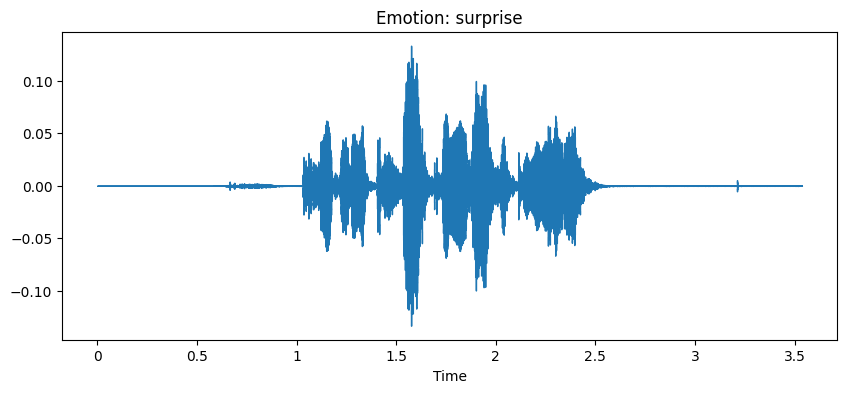

In [9]:
import librosa.display
import matplotlib.pyplot as plt

# Preview sample
sample_file = audio_files[0]
y, sr = librosa.load(sample_file, sr=None)
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Emotion: {labels[0]}")
plt.show()


#2.   Feature Extraction



In [10]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    y, _ = librosa.effects.trim(y)
    y = y / np.max(np.abs(y))

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)

    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)

    # Spectral
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_centroid_mean = np.mean(spec_centroid)
    spec_centroid_std = np.std(spec_centroid)

    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spec_bandwidth_mean = np.mean(spec_bandwidth)
    spec_bandwidth_std = np.std(spec_bandwidth)

    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spec_contrast_mean = np.mean(spec_contrast, axis=1)
    spec_contrast_std = np.std(spec_contrast, axis=1)

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(zcr)
    zcr_std = np.std(zcr)

    # RMS Energy
    rms = librosa.feature.rms(y=y)
    rms_mean = np.mean(rms)
    rms_std = np.std(rms)

    # Pitch
    snd = parselmouth.Sound(file_path)
    pitch = snd.to_pitch()
    pitch_values = pitch.selected_array['frequency']
    pitch_values = pitch_values[pitch_values > 0]  # remove unvoiced
    pitch_mean = np.mean(pitch_values) if len(pitch_values) > 0 else 0
    pitch_std = np.std(pitch_values) if len(pitch_values) > 0 else 0

    # Combine all features
    features = np.concatenate([
        mfccs_mean, mfccs_std,
        chroma_mean, chroma_std,
        [spec_centroid_mean, spec_centroid_std],
        [spec_bandwidth_mean, spec_bandwidth_std],
        spec_contrast_mean, spec_contrast_std,
        [zcr_mean, zcr_std],
        [rms_mean, rms_std],
        [pitch_mean, pitch_std]
    ])

    return features


In [11]:
# Extract Features for All Files
features_list = []

for i, file in enumerate(audio_files):
    try:
        features = extract_features(file)
        features_list.append(features)
    except Exception as e:
        print(f"Error processing {file}: {e}")
    if i % 50 == 0:
        print(f"Processed {i} files...")


Processed 0 files...
Processed 50 files...
Processed 100 files...
Processed 150 files...
Processed 200 files...
Processed 250 files...
Processed 300 files...
Processed 350 files...
Processed 400 files...
Processed 450 files...
Processed 500 files...
Processed 550 files...
Processed 600 files...
Processed 650 files...
Processed 700 files...
Processed 750 files...
Processed 800 files...
Processed 850 files...
Processed 900 files...
Processed 950 files...
Processed 1000 files...
Processed 1050 files...
Processed 1100 files...
Processed 1150 files...
Processed 1200 files...
Processed 1250 files...
Processed 1300 files...
Processed 1350 files...
Processed 1400 files...


In [12]:
# Save Features and Labels to CSV

features_array = np.array(features_list)
df = pd.DataFrame(features_array)

# Add emotion labels
df['label'] = labels

df.to_csv("ravdess_features.csv", index=False)
print("Feature extraction complete! CSV saved as 'ravdess_features.csv'.")


Feature extraction complete! CSV saved as 'ravdess_features.csv'.


### Verification

In [13]:
df.to_csv("ravdess_features.csv", index=False)


In [14]:
import pandas as pd

df_check = pd.read_csv("ravdess_features.csv")
print(df_check.shape)  # should be (num_files, num_features + 1)
print(df_check.head())  # see the first few rows
print(df_check['label'].value_counts())  # check labels distribution


(1440, 75)
            0           1          2          3         4         5  \
0 -347.528473   75.398186 -20.777817   7.245049 -1.304669  1.905878   
1 -341.041046  100.728188  -1.726990  10.210053 -3.251192  4.211567   
2 -308.459778  108.860756 -24.310974  12.489736 -8.947667 -4.503085   
3 -266.132111  117.005676 -31.595842  11.265224 -9.181322 -5.302297   
4 -354.196991   90.898682  -6.012326  12.777288 -5.529985  6.887789   

           6         7          8          9  ...        65        66  \
0 -19.326124  5.012340 -10.328639  -2.786185  ...  4.617819  4.291005   
1 -14.752342 -1.443869 -19.810442  -9.909456  ...  6.090873  4.404170   
2 -13.701671  3.829292 -17.254562 -11.522161  ...  5.230767  4.594294   
3 -17.472898  2.562342 -22.194511 -14.531348  ...  5.574087  4.922151   
4 -12.712231  2.873382 -13.197560  -5.861185  ...  5.243134  4.426494   

         67        68        69        70        71          72         73  \
0  6.725268  0.091498  0.061976  0.067915  0.

In [15]:
import IPython.display as ipd
import random

i = random.randint(0, len(audio_files)-1)
print(f"Label: {labels[i]}")
ipd.Audio(audio_files[i])


Label: angry


### Data preprocessing for lstm

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical


In [17]:
# Separate features (X) and labels (y)
X = df_check.drop('label', axis=1).values
y = df_check['label'].values



In [18]:
# Encode the labels (emotions)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)



In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)



In [20]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [21]:
# LSTM requires a 3D input: [samples, timesteps, features]
# For this feature set, we treat each sample as having 1 timestep.
# Shape of original features: (samples, total_features) -> (1440, 74)
# Shape after scaling: (samples, 74)
# Reshape to: (samples, 1, 74)
X_train_lstm = np.expand_dims(X_train_scaled, axis=1)
X_test_lstm = np.expand_dims(X_test_scaled, axis=1)



In [22]:
# Verification of shapes
print(f"Original features shape: {X.shape}")
print(f"Encoded labels shape: {y_categorical.shape}")
print(f"Train features shape for LSTM: {X_train_lstm.shape}")
print(f"Test features shape for LSTM: {X_test_lstm.shape}")

Original features shape: (1440, 74)
Encoded labels shape: (1440, 8)
Train features shape for LSTM: (1152, 1, 74)
Test features shape for LSTM: (288, 1, 74)


# 3. Training

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define constants from the preprocessed data
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
num_classes = y_categorical.shape[1]



In [24]:
# Build the LSTM model
model = Sequential([
    # LSTM layer (input_shape specified only in the first layer)
    LSTM(128, input_shape=input_shape, return_sequences=False),

    # Dense layer for feature consolidation
    Dense(128, activation='relu'),

    # Dropout for regularization
    Dropout(0.3),

    # Output layer with softmax activation for classification
    Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       103,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,480 (474.53 KB)

 Trainable params: 121,480 (474.53 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [27]:
# Train the model
history_new = model.fit(
    X_train_lstm,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_lstm, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.2324 - loss: 2.0049 - val_accuracy: 0.3333 - val_loss: 1.8162
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3956 - loss: 1.7485 - val_accuracy: 0.4479 - val_loss: 1.6095
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5054 - loss: 1.5082 - val_accuracy: 0.5347 - val_loss: 1.3960
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5806 - loss: 1.2609 - val_accuracy: 0.5694 - val_loss: 1.2660
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6224 - loss: 1.1149 - val_accuracy: 0.5694 - val_loss: 1.1660
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6845 - loss: 0.9993 - val_accuracy: 0.6146 - val_loss: 1.0788
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6953 - loss: 0.8964 - val_accuracy: 0.6319 - val_loss: 1.0091
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7248 - loss: 0.8184 - val_accuracy: 0.6493 - val_loss

In [28]:
# Save the trained model
model.save("emotion_lstm_model.h5")
print(" Model saved")


 Model saved


In [34]:
from tensorflow.keras.models import load_model

# Load the trained model
loaded_model = load_model("emotion_lstm_model.h5")
print(" Model loaded")


 Model loaded


In [35]:
# Predict probabilities on the 3D test feature set
y_pred_test = model.predict(X_test_lstm, verbose=0)

# Convert predicted probabilities (one-hot encoded) to class labels (indices)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Convert true labels (one-hot encoded) to class labels (indices)
y_test_classes = np.argmax(y_test, axis=1)

In [36]:
# Calculate the final test accuracy
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test_classes, y_pred_test_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 72.92%
